In [ ]:
#QCI hardware real Dirac-1 22/02/05

In [2]:
import importlib.metadata
print(importlib.metadata.version("qci-client"))



4.5.0


In [2]:
import os
import networkx as nx
import numpy as np
import qci_client as qc
import pandas as pd
from itertools import product
from tabulate import tabulate
import matplotlib.pyplot as plt
import time

# Configura API y token de QCI
os.environ['QCI_API_URL'] = 'https://api.qci-prod.com'
os.environ['QCI_TOKEN'] = 'Token'
num_samples=10

# Crear un grafo de 4 nodos con 4 aristas
edges = {(0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1}
G = nx.Graph()
G.add_edges_from(edges)

# Ver el grafo
print("Nodos:", G.nodes)
print("Aristas:", G.edges)

# Construcción del QUBO
n = len(G.nodes)
Q = np.zeros((n, n))

#Lógica obtenida de bibliografía de QCI
# Llenar la matriz QUBO basándonos en las aristas del grafo
for u, v in G.edges:
    Q[u, v] += 1
    Q[v, u] += 1
    Q[u, u] -= 1
    Q[v, v] -= 1

# Mostrar la matriz QUBO
print("Matriz QUBO:")
print(Q)

# Crear un cliente QCI
client = qc.QciClient()

# Definir el QUBO
file_def = {
    "file_name": "max-cut-example",
    "file_config": {
        "qubo": {
            "data": Q
        }
    }
}

# Subir el archivo QUBO a QCI
response = client.upload_file(file=file_def)
file_id = response["file_id"]
print(f"File ID: {file_id}")

# Crear el trabajo y enviarlo a QCI
job_body = client.build_job_body(
    job_type="sample-qubo",  
    qubo_file_id=file_id,
    job_params={"device_type": "dirac-1", "num_samples": num_samples}
)
job_response = client.process_job(job_body=job_body)

# Ver el ID del trabajo
job_id = job_response.get("job_info", {}).get("job_id", "Desconocido")
print(f"Trabajo enviado con ID: {job_id}")

# Esperar a que el trabajo se complete
job_status = client.get_job_status(job_id=job_id)
while job_status["status"] not in ["COMPLETED", "FAILED"]:
    print(f"Estado del trabajo: {job_status['status']}")
    time.sleep(5)
    job_status = client.get_job_status(job_id=job_id)

# Obtener los resultados
if job_status["status"] == "COMPLETED":
    results = client.get_job_results(job_id=job_id)
    print("Resultados obtenidos:")
    print(results)
else:
    print("El trabajo falló.")
    exit()

# Procesar los resultados
solutions = results["results"]["solutions"]


Nodos: [0, 1, 2, 3]
Aristas: [(0, 1), (0, 3), (1, 2), (2, 3)]
Matriz QUBO:
[[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]
File ID: 6803fdc95e08552632285061
2025-04-19 21:47:22 - Dirac allocation balance = 354 s
2025-04-19 21:47:22 - Job submitted: job_id='6803fdca6f2d98bd02a355e9'
2025-04-19 21:47:22 - RUNNING
2025-04-19 22:10:12 - COMPLETED
2025-04-19 22:10:14 - Dirac allocation balance = 334 s
Trabajo enviado con ID: 6803fdca6f2d98bd02a355e9
Resultados obtenidos:
{'job_info': {'job_id': '6803fdca6f2d98bd02a355e9', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '6803fdc95e08552632285061'}}, 'device_config': {'dirac-1': {'num_samples': 100}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-04-19T19:47:22.5Z', 'queued_at_rfc3339nano': '2025-04-19T19:47:22.5Z', 'running_at_rfc3339nano': '2025-04-19T19:47:22.584Z', 'completed_at_rfc3339nano': '2025-04-19T20:10:10.808Z'}, 'job_result': {'file_id': '68040

In [3]:
print("Estructura de solutions:")
print(results)

Estructura de solutions:
{'job_info': {'job_id': '6803fdca6f2d98bd02a355e9', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '6803fdc95e08552632285061'}}, 'device_config': {'dirac-1': {'num_samples': 100}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-04-19T19:47:22.5Z', 'queued_at_rfc3339nano': '2025-04-19T19:47:22.5Z', 'running_at_rfc3339nano': '2025-04-19T19:47:22.584Z', 'completed_at_rfc3339nano': '2025-04-19T20:10:10.808Z'}, 'job_result': {'file_id': '680403225e08552632285063', 'device_usage_s': 20}}, 'status': 'COMPLETED', 'results': {'counts': [56, 44], 'energies': [-4, -4], 'solutions': [[1, 0, 1, 0], [0, 1, 0, 1]]}}


In [7]:
counts = results["results"]["counts"]

# Generar todas las combinaciones posibles de 4 bits
all_combinations = list(product([0, 1], repeat=4)) 

# Crear un diccionario para contar las ocurrencias de cada combinación
count_dict = {combination: 0 for combination in all_combinations}

# Contar las ocurrencias de cada combinación en los resultados
for solution, count in zip(solutions, counts):
    sample_state = tuple(solution)  
    count_dict[sample_state] += count 

# Crear una tabla con todas las combinaciones y sus conteos
table_data = []
for combination, count in count_dict.items():
    table_data.append([combination, count])

# Encabezados de la tabla
headers = ["Combinación", "Conteo"]

# Imprimir la tabla
print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=headers, tablefmt="pretty"))

# Definir los estados óptimos (para Max-Cut)
opt_states = [(0, 1, 0, 1), (1, 0, 1, 0)]  
opt_value = 4  
device_time_s = results["job_info"]["job_result"]["device_usage_s"]
# Función para calcular P_GS y TTS
t_sample = (device_time_s * 1000) / num_samples 

# Función para calcular P_GS y TTS con fórmula robusta
def calculate_P_GS_and_TTS(count_dict, opt_states, t_sample, num_samples):
    success_counts = sum(count_dict[state] for state in opt_states)
    p_gs = success_counts / num_samples

    if p_gs == 1:
        tts = t_sample  # Si todos los samples son óptimos
    elif p_gs == 0:
        tts = float("inf")  # No se encontró solución óptima
    else:
        tts = t_sample * np.max([1, np.abs(np.log(0.01) / np.log(1 - p_gs))])

    return p_gs, tts
    
# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(count_dict, opt_states, t_sample, num_samples)
print("\nMétricas:")
print("P_GS:", p_gs)
print("TTS:", tts, "ms")


# 🔹 Crear tabla en Jupyter
data = {
    "Instance": ["(4, 4, 0)"],  # Identificador del grafo
    "Opt": [opt_value],         # Valor óptimo
    "P_GS": [p_gs],             # Probabilidad de éxito
    "t_sample (ms)": [t_sample], # Tiempo por muestra
    "TTS (ms)": [tts]           # Time to Solution
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
print("\nTabla de métricas:")
display(df)



Conteo de todas las combinaciones:
+--------------+--------+
| Combinación  | Conteo |
+--------------+--------+
| (0, 0, 0, 0) |   0    |
| (0, 0, 0, 1) |   0    |
| (0, 0, 1, 0) |   0    |
| (0, 0, 1, 1) |   0    |
| (0, 1, 0, 0) |   0    |
| (0, 1, 0, 1) |   44   |
| (0, 1, 1, 0) |   0    |
| (0, 1, 1, 1) |   0    |
| (1, 0, 0, 0) |   0    |
| (1, 0, 0, 1) |   0    |
| (1, 0, 1, 0) |   56   |
| (1, 0, 1, 1) |   0    |
| (1, 1, 0, 0) |   0    |
| (1, 1, 0, 1) |   0    |
| (1, 1, 1, 0) |   0    |
| (1, 1, 1, 1) |   0    |
+--------------+--------+

Métricas:
P_GS: 1.0
TTS: 200.0 ms

Tabla de métricas:


,Instance,Opt,P_GS,t_sample (ms),TTS (ms)
0,"(4, 4, 0)",4,1.0,200.0,200.0


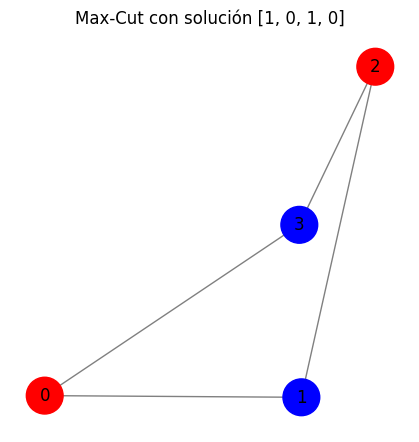

In [8]:
# Visualizar el grafo con la mejor solución
best_solution = solutions[0] 
node_colors = ['red' if bit == 1 else 'blue' for bit in best_solution]

# Crear el grafo
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (0, 3)]) 

# Dibujar el grafo
plt.figure(figsize=(4,4))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=700)
plt.title(f"Max-Cut con solución {best_solution}")
plt.show()

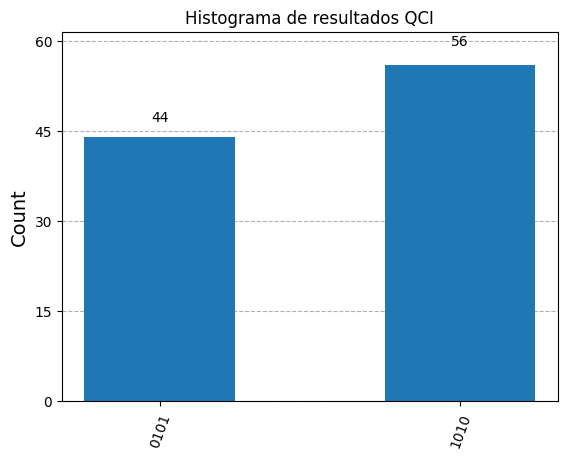

In [5]:
from qiskit.visualization import plot_histogram

# Convertir count_dict a formato compatible con Qiskit
qiskit_counts = {"".join(map(str, k)): v for k, v in count_dict.items() if v > 0}

# Mostrar el histograma estilo Qiskit
plot_histogram(qiskit_counts, title="Histograma de resultados QCI")
